In [1]:
# from huggingface_hub import notebook_login

# notebook_login()

In [2]:
# !huggingface-cli login 

In [3]:
!huggingface-cli whoami

jclynn
orgs:  pinnacleaerospace


# Prerequisites

In [4]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

from sklearn.model_selection  import train_test_split

import numpy as np
from datetime import datetime, date
import time

# DeepSpeed ZeRO-3
import deepspeed
from deepspeed.accelerator import get_accelerator

/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


[2024-05-14 11:08:58,504] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_audit_symbind_alt@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__nptl_change_stack_perm@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_find_dso_for_object@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_fatal_printf@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_exception_create@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__tunable_get_val@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_audit_preinit@GLIBC_PRI

 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# device = torch.device('cpu')
print(device)

cuda


In [7]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 23.25750732421875, Global(GB): 23.64971923828125, Free(%): 0.9834157898404292


# Load Excel File

In [8]:
import pandas as pd
master_df = pd.read_excel('./DATASETS/Training_Dataset.xlsx')
master_df.head()

,Type,Identity,Text,A2-Unambiguous,A4-Tolerances,A5-Sources specified,E1
0,GSS_CONNECTIVITY,SRD_GSS_FUNC_61,The User and Rights Administration HMI shall p...,1,na,na,1
1,Cobham_ATR,SHLR-ATR2146,The Network Function shall support WiFi 802.11...,1,na,na,1
2,Cobham_ATR,SHLR-ATR797,The PwrCon software shall monitor the output v...,1,na,na,1
3,Cobham_ATR,SHLR-ATR3013,"When prompted, the TETRA Software shall place ...",1,na,na,1
4,Cobham_ATR,SHLR-ATR3198,The TETRA software shall allow users to select...,1,na,na,1


In [9]:
model_df = master_df[['E1','Text']].copy()
model_df.head()

,E1,Text
0,1,The User and Rights Administration HMI shall p...
1,1,The Network Function shall support WiFi 802.11...
2,1,The PwrCon software shall monitor the output v...
3,1,"When prompted, the TETRA Software shall place ..."
4,1,The TETRA software shall allow users to select...


In [10]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3255 entries, 0 to 3254
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E1      3255 non-null   int64 
 1   Text    3255 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


In [11]:
model_df_label1 = model_df.query('E1 == 1')
len(model_df_label1)

2127

In [12]:
model_df_label0 = model_df.query('E1 == 0')
len(model_df_label0)

1128

In [13]:
model_df = pd.concat([model_df_label1[:1000],model_df_label0])

# Data process and tokenizer

In [14]:
from sklearn.model_selection  import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.1, shuffle=True)

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [15]:
len(train_df)

1915

In [16]:
tokenizer = torch.hub.load(
    "huggingface/pytorch-transformers",
    "tokenizer",
    # "meta-llama/Llama-2-7b-hf",
    "meta-llama/Meta-Llama-3-8B",
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
tokenizer

PreTrainedTokenizerFast(name_or_path='meta-llama/Meta-Llama-3-8B', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|reserved_special_token_2|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128005: AddedToken("<|r

# Dataset iterator

In [18]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [19]:
next(train_iter)

(0,
 'The moduleServersApp (configured for PC-24) shall be capable of sending maintenance files, achievable through HTTP requests with URI in a determined format.')

In [20]:
from torch.utils.data import DataLoader

# function passed to the DataLoader to process a batch of data as indicated
tokenizer.pad_token = tokenizer.eos_token

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)  
    
    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return encoded_x, torch.tensor(y, dtype=torch.long).to(device)

In [21]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
first = next(train_iter)
second = next(train_iter)

print(first)
print(second)

collate_batch([first, second])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


(1, 'The FTP server shall set the data connection timeout specified in the Customization file')
(0, 'The system shall be efficient.')


({'input_ids': [[128000, 791, 48650, 3622, 4985, 743, 279, 828, 3717, 9829, 5300, 304, 279, 8572, 2065, 1052], [128000, 791, 1887, 4985, 387, 11297, 13, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001, 128001]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
 tensor([1, 0], device='cuda:0'))

In [22]:
import torch

# DeepSpeed ZeRO-3
import deepspeed
from deepspeed.accelerator import get_accelerator


with deepspeed.zero.Init():
    model = torch.hub.load(
        "huggingface/pytorch-transformers",
        "modelForSequenceClassification",
        # "meta-llama/Llama-2-7b-hf",
        "meta-llama/Meta-Llama-3-8B",
        ignore_mismatched_sizes=True
    )

[2024-05-14 11:08:01,992] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-05-14 11:08:01,992] [INFO] [comm.py:652:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2024-05-14 11:08:02,091] [INFO] [comm.py:702:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=10.1.1.204, master_port=29500
[2024-05-14 11:08:02,092] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[W CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())
Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized because the shapes did not match:
- model.embed_tokens.weight: found shape torch.Size([128256, 4096]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.input_layernorm.weight: found shape torch.Size([4096]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.mlp.down_proj.weight: found shape torch.Size([4096, 14336]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.mlp.gate_proj.weight: found shape torch.Size([14336, 4096]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.mlp.up_proj.weight: found shape torch.Size([14336, 4096]) in the checkpoint and torch.Size([0]) in the model instantiated
- model.layers.0.post_attention_layernorm.weight: found shape torch.Size([4096]) in the checkpoint and torch.Size([0]) in the m

[2024-05-14 11:08:03,490] [INFO] [partition_parameters.py:345:__exit__] finished initializing model - num_params = 291, num_elems = 7.50B


In [23]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
 

In [10]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

NameError: name 'train_iter' is not defined

In [11]:
for i, parameter in enumerate(model.parameters()):
    parameter.requires_grad = False

In [15]:
model.score = nn.Linear(in_features=4096, out_features=2)
model.config.pad_token_id = tokenizer.pad_token_id

In [16]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
 

# Train and eval functions

In [28]:
from datetime import datetime, date
import time

def train(model, dataloader, epoch):
    
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0


    for idx, (data, label) in enumerate(dataloader):         
        optimizer.zero_grad()
        
        outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
        predicted_label = outputs.logits
        loss = criterion(predicted_label, label)
        
        # Deepspeed model engine, backward pass 
        model.backward(loss)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Deepspeed model engine, optimizer step
        model.step()
        
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        # Deepspeed model engine, empty cache
        model.empty_partition_cache()
        
    return total_acc / total_count, total_loss / total_count
        

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):      
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
            loss = criterion(predicted_label, label)
            
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

# Deepspeed

In [29]:
deepspeed_config = {
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.01,
            "betas": [
                0.8,
                0.999
            ],
            "eps": 1e-8,
            "weight_decay": 3e-7,
        },
    },
    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": 0,
            "warmup_max_lr": 0.01,
            "warmup_num_steps": 1000,
        },
    },
    "train_batch_size": 16,
    # "train_micro_batch_size_per_gpu": "auto",
    # "gradient_accumulation_steps": "auto",
    "fp16": {"enabled": True},
    "zero_optimization": {
        "stage": 3,
        "offload_optimizer": {
            "device": "cpu",
        },
        "offload_param": {
            "device": "cpu",
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "overlap_comm": True,
        "load_from_fp32_weights": True,
        "gather_16bit_weights_on_model_save": True,
        "contiguous_gradients": True,
        "stage3_prefetch_bucket_size": 0,
    },
    "gradient_accumulation_steps": 1,
    "train_batch_size": 16,
}

# Initialize DeepSpeed Engine
model_engine, optimizer, _, lr_scheduler = deepspeed.initialize(
    model=model,
    model_parameters=model.parameters(),
    config=deepspeed_config,
)
model_engine

[2024-05-14 07:58:59,624] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.14.2, git-hash=unknown, git-branch=unknown
[2024-05-14 07:58:59,635] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2024-05-14 07:59:00,695] [WARNING] [cpu_adam.py:84:__init__] FP16 params for CPUAdam may not work on AMD CPUs
Installed CUDA version 12.3 does not match the version torch was compiled with 12.1 but since the APIs are compatible, accepting this combination


Using /home/it/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/it/.cache/torch_extensions/py311_cu121/cpu_adam/build.ninja...
/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Time to load cpu_adam op: 2.182269334793091 seconds


Loading extension module cpu_adam...


[2024-05-14 07:59:03,277] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adam as basic optimizer
[2024-05-14 07:59:03,277] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-05-14 07:59:03,282] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-05-14 07:59:03,282] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-05-14 07:59:03,282] [INFO] [logging.py:96:log_dist] [Rank 0] Creating fp16 ZeRO stage 3 optimizer, MiCS is enabled False, Hierarchical params gather False
[2024-05-14 07:59:03,283] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float16 ZeRO stage 3 optimizer
[2024-05-14 07:59:03,372] [INFO] [utils.py:779:see_memory_usage] Stage 3 initialize beginning
Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: 

[2024-05-14 07:59:04,200] [INFO] [config.py:1000:print]   curriculum_enabled_legacy .... False
[2024-05-14 07:59:04,200] [INFO] [config.py:1000:print]   curriculum_params_legacy ..... False
[2024-05-14 07:59:04,200] [INFO] [config.py:1000:print]   data_efficiency_config ....... {'enabled': False, 'seed': 1234, 'data_sampling': {'enabled': False, 'num_epochs': 1000, 'num_workers': 0, 'curriculum_learning': {'enabled': False}}, 'data_routing': {'enabled': False, 'random_ltd': {'enabled': False, 'layer_token_lr_schedule': {'enabled': False}}}}
[2024-05-14 07:59:04,201] [INFO] [config.py:1000:print]   data_efficiency_enabled ...... False
[2024-05-14 07:59:04,201] [INFO] [config.py:1000:print]   dataloader_drop_last ......... False
[2024-05-14 07:59:04,201] [INFO] [config.py:1000:print]   disable_allgather ............ False
[2024-05-14 07:59:04,201] [INFO] [config.py:1000:print]   dump_state ................... False
[2024-05-14 07:59:04,201] [INFO] [config.py:1000:print]   dynamic_loss_sc

[2024-05-14 07:59:04,205] [INFO] [config.py:1000:print]   zero_force_ds_cpu_optimizer .. True
[2024-05-14 07:59:04,206] [INFO] [config.py:1000:print]   zero_optimization_stage ...... 3
[2024-05-14 07:59:04,206] [INFO] [config.py:986:print_user_config]   json = {
    "optimizer": {
        "type": "Adam", 
        "params": {
            "lr": 0.01, 
            "betas": [0.8, 0.999], 
            "eps": 1e-08, 
            "weight_decay": 3e-07
        }
    }, 
    "scheduler": {
        "type": "WarmupLR", 
        "params": {
            "warmup_min_lr": 0, 
            "warmup_max_lr": 0.01, 
            "warmup_num_steps": 1000
        }
    }, 
    "train_batch_size": 16, 
    "fp16": {
        "enabled": true
    }, 
    "zero_optimization": {
        "stage": 3, 
        "offload_optimizer": {
            "device": "cpu"
        }, 
        "offload_param": {
            "device": "cpu"
        }, 
        "allgather_partitions": true, 
        "allgather_bucket_size": 2.000000

DeepSpeedEngine(
  (module): LlamaForSequenceClassification(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 4096)
      (layers): ModuleList(
        (0-31): 32 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm()
          (post_attention_la

In [30]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = get_accelerator().device_name(model_engine.local_rank)
device

'cuda:0'

# Split the dataset and run the model

In [38]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 16  # batch size for training

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [43]:
today = date.today().isoformat()
model_name = "llama3_8b"
checkpoint_path = f"./models/{model_name}"


# Hyperparameters
# EPOCHS = 20  # epoch
# LR = 5 # learning rate
    
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    
def train_with_hist(model, epochs):
    model = model.to(device)
    
    total_accu = None
    best_accu_val = 0.85

    loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = [], [], [], []
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train(model, train_dataloader, epoch)
        accu_val, loss_val = evaluate(model, valid_dataloader)

        print({
            "epoch": epoch,
            "loss_train": loss_train,
            "loss_val": loss_val,
            "accuracy_train": accu_train,
            "accuracy_val": accu_val,
        })
        
        loss_hist_train.append(loss_train)
        loss_hist_valid.append(loss_val)
        accuracy_hist_train.append(accu_train)
        accuracy_hist_valid.append(accu_val)
        
        get_accelerator().empty_cache()
        
        if accu_val > best_accu_val:
            best_accu_val = accu_val
            model_engine.save_16bit_model(f"./models/{model_name}/", f"{today}_{model_name}_checkpoint.pth")
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [44]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [48]:
hist = train_with_hist(model_engine, epochs=18)

[2024-05-14 08:07:40,352] [INFO] [logging.py:96:log_dist] [Rank 0] step=290, skipped=17, lr=[0.00812054215680252], mom=[[0.8, 0.999]]
[2024-05-14 08:07:40,352] [INFO] [timer.py:260:stop] epoch=0/micro_step=290/global_step=290, RunningAvgSamplesPerSec=71.25409471118829, CurrSamplesPerSec=75.93226966765067, MemAllocated=14.65GB, MaxMemAllocated=16.29GB
[2024-05-14 08:07:43,654] [INFO] [logging.py:96:log_dist] [Rank 0] step=300, skipped=17, lr=[0.008172621451747636], mom=[[0.8, 0.999]]
[2024-05-14 08:07:43,655] [INFO] [timer.py:260:stop] epoch=0/micro_step=300/global_step=300, RunningAvgSamplesPerSec=71.51964720213398, CurrSamplesPerSec=87.07916409853827, MemAllocated=14.61GB, MaxMemAllocated=16.29GB
[2024-05-14 08:07:46,904] [INFO] [logging.py:96:log_dist] [Rank 0] step=310, skipped=17, lr=[0.008222892067847033], mom=[[0.8, 0.999]]
[2024-05-14 08:07:46,905] [INFO] [timer.py:260:stop] epoch=0/micro_step=310/global_step=310, RunningAvgSamplesPerSec=71.79626323528812, CurrSamplesPerSec=75.9

[2024-05-14 08:09:09,037] [INFO] [timer.py:260:stop] epoch=0/micro_step=510/global_step=510, RunningAvgSamplesPerSec=71.24527013853147, CurrSamplesPerSec=101.3842393258461, MemAllocated=14.59GB, MaxMemAllocated=16.29GB
[2024-05-14 08:09:12,577] [INFO] [logging.py:96:log_dist] [Rank 0] step=520, skipped=17, lr=[0.009005226616853091], mom=[[0.8, 0.999]]
[2024-05-14 08:09:12,578] [INFO] [timer.py:260:stop] epoch=0/micro_step=520/global_step=520, RunningAvgSamplesPerSec=71.2090584932092, CurrSamplesPerSec=72.56039936466678, MemAllocated=14.65GB, MaxMemAllocated=16.29GB
[2024-05-14 08:09:15,933] [INFO] [logging.py:96:log_dist] [Rank 0] step=530, skipped=17, lr=[0.009033724550372721], mom=[[0.8, 0.999]]
[2024-05-14 08:09:15,934] [INFO] [timer.py:260:stop] epoch=0/micro_step=530/global_step=530, RunningAvgSamplesPerSec=71.2862274794714, CurrSamplesPerSec=88.31229207899945, MemAllocated=14.59GB, MaxMemAllocated=16.29GB
[2024-05-14 08:09:19,640] [INFO] [logging.py:96:log_dist] [Rank 0] step=540

[2024-05-14 08:10:40,141] [INFO] [logging.py:96:log_dist] [Rank 0] step=740, skipped=17, lr=[0.00953046099098177], mom=[[0.8, 0.999]]
[2024-05-14 08:10:40,141] [INFO] [timer.py:260:stop] epoch=0/micro_step=740/global_step=740, RunningAvgSamplesPerSec=71.54322061314373, CurrSamplesPerSec=67.9626103107233, MemAllocated=14.68GB, MaxMemAllocated=16.29GB
[2024-05-14 08:10:43,500] [INFO] [logging.py:96:log_dist] [Rank 0] step=750, skipped=17, lr=[0.009550346582137093], mom=[[0.8, 0.999]]
[2024-05-14 08:10:43,500] [INFO] [timer.py:260:stop] epoch=0/micro_step=750/global_step=750, RunningAvgSamplesPerSec=71.58473557563757, CurrSamplesPerSec=67.75716455041841, MemAllocated=14.68GB, MaxMemAllocated=16.29GB
[2024-05-14 08:10:47,005] [INFO] [logging.py:96:log_dist] [Rank 0] step=760, skipped=17, lr=[0.009569962712535253], mom=[[0.8, 0.999]]
[2024-05-14 08:10:47,006] [INFO] [timer.py:260:stop] epoch=0/micro_step=760/global_step=760, RunningAvgSamplesPerSec=71.56471110875897, CurrSamplesPerSec=109.3

[2024-05-14 08:12:08,398] [INFO] [timer.py:260:stop] epoch=0/micro_step=960/global_step=960, RunningAvgSamplesPerSec=71.50248765913146, CurrSamplesPerSec=115.68080452181528, MemAllocated=14.55GB, MaxMemAllocated=16.29GB
{'epoch': 7, 'loss_train': 9.461965013110606e-06, 'loss_val': 0.0016943231886422977, 'accuracy_train': 1.0, 'accuracy_val': 0.7049608355091384}
[2024-05-14 08:12:17,720] [INFO] [logging.py:96:log_dist] [Rank 0] step=970, skipped=17, lr=[0.009930309668794421], mom=[[0.8, 0.999]]
[2024-05-14 08:12:17,720] [INFO] [timer.py:260:stop] epoch=0/micro_step=970/global_step=970, RunningAvgSamplesPerSec=71.55868257122411, CurrSamplesPerSec=82.84860830253155, MemAllocated=14.63GB, MaxMemAllocated=16.29GB
[2024-05-14 08:12:21,255] [INFO] [logging.py:96:log_dist] [Rank 0] step=980, skipped=17, lr=[0.009945420957081782], mom=[[0.8, 0.999]]
[2024-05-14 08:12:21,255] [INFO] [timer.py:260:stop] epoch=0/micro_step=980/global_step=980, RunningAvgSamplesPerSec=71.54263863540045, CurrSamples

[2024-05-14 08:13:45,980] [INFO] [logging.py:96:log_dist] [Rank 0] step=1190, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:13:45,981] [INFO] [timer.py:260:stop] epoch=0/micro_step=1190/global_step=1190, RunningAvgSamplesPerSec=71.53713020314703, CurrSamplesPerSec=100.40720741748171, MemAllocated=14.57GB, MaxMemAllocated=16.29GB
[2024-05-14 08:13:49,363] [INFO] [logging.py:96:log_dist] [Rank 0] step=1200, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:13:49,364] [INFO] [timer.py:260:stop] epoch=0/micro_step=1200/global_step=1200, RunningAvgSamplesPerSec=71.55667247838049, CurrSamplesPerSec=72.26979456981998, MemAllocated=14.66GB, MaxMemAllocated=16.29GB
[2024-05-14 08:13:52,778] [INFO] [logging.py:96:log_dist] [Rank 0] step=1210, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:13:52,779] [INFO] [timer.py:260:stop] epoch=0/micro_step=1210/global_step=1210, RunningAvgSamplesPerSec=71.57155990547602, CurrSamplesPerSec=46.764031711720754, MemAllocated=14.8GB, 

[2024-05-14 08:15:18,332] [INFO] [timer.py:260:stop] epoch=0/micro_step=1420/global_step=1420, RunningAvgSamplesPerSec=71.4071199030674, CurrSamplesPerSec=87.72641340481242, MemAllocated=14.61GB, MaxMemAllocated=16.29GB
[2024-05-14 08:15:22,115] [INFO] [logging.py:96:log_dist] [Rank 0] step=1430, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:15:22,116] [INFO] [timer.py:260:stop] epoch=0/micro_step=1430/global_step=1430, RunningAvgSamplesPerSec=71.33934134553141, CurrSamplesPerSec=65.75593562452539, MemAllocated=14.68GB, MaxMemAllocated=16.29GB
[2024-05-14 08:15:25,369] [INFO] [logging.py:96:log_dist] [Rank 0] step=1440, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:15:25,369] [INFO] [timer.py:260:stop] epoch=0/micro_step=1440/global_step=1440, RunningAvgSamplesPerSec=71.38711811531228, CurrSamplesPerSec=99.26891518288363, MemAllocated=14.58GB, MaxMemAllocated=16.29GB
{'epoch': 12, 'loss_train': 4.983563024754935e-06, 'loss_val': 1.4282704644663837e-05, 'accuracy_t

[2024-05-14 08:16:56,529] [INFO] [timer.py:260:stop] epoch=0/micro_step=1650/global_step=1650, RunningAvgSamplesPerSec=71.36466339704769, CurrSamplesPerSec=92.28378948873832, MemAllocated=14.59GB, MaxMemAllocated=16.29GB
[2024-05-14 08:16:59,776] [INFO] [logging.py:96:log_dist] [Rank 0] step=1660, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:16:59,777] [INFO] [timer.py:260:stop] epoch=0/micro_step=1660/global_step=1660, RunningAvgSamplesPerSec=71.40440993287626, CurrSamplesPerSec=75.51802234182978, MemAllocated=14.65GB, MaxMemAllocated=16.29GB
[2024-05-14 08:17:03,266] [INFO] [logging.py:96:log_dist] [Rank 0] step=1670, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:17:03,267] [INFO] [timer.py:260:stop] epoch=0/micro_step=1670/global_step=1670, RunningAvgSamplesPerSec=71.39966350552986, CurrSamplesPerSec=43.75430411157895, MemAllocated=14.83GB, MaxMemAllocated=16.29GB
[2024-05-14 08:17:07,050] [INFO] [logging.py:96:log_dist] [Rank 0] step=1680, skipped=18, lr=[0.0

[2024-05-14 08:18:31,913] [INFO] [logging.py:96:log_dist] [Rank 0] step=1890, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:18:31,914] [INFO] [timer.py:260:stop] epoch=0/micro_step=1890/global_step=1890, RunningAvgSamplesPerSec=71.31570257990259, CurrSamplesPerSec=98.63525649128273, MemAllocated=14.58GB, MaxMemAllocated=16.29GB
[2024-05-14 08:18:35,183] [INFO] [logging.py:96:log_dist] [Rank 0] step=1900, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:18:35,183] [INFO] [timer.py:260:stop] epoch=0/micro_step=1900/global_step=1900, RunningAvgSamplesPerSec=71.35153191179701, CurrSamplesPerSec=75.43279780498196, MemAllocated=14.65GB, MaxMemAllocated=16.29GB
[2024-05-14 08:18:38,539] [INFO] [logging.py:96:log_dist] [Rank 0] step=1910, skipped=18, lr=[0.01], mom=[[0.8, 0.999]]
[2024-05-14 08:18:38,540] [INFO] [timer.py:260:stop] epoch=0/micro_step=1910/global_step=1910, RunningAvgSamplesPerSec=71.37338436307287, CurrSamplesPerSec=82.76237386879642, MemAllocated=14.62GB, M

In [49]:
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curves(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

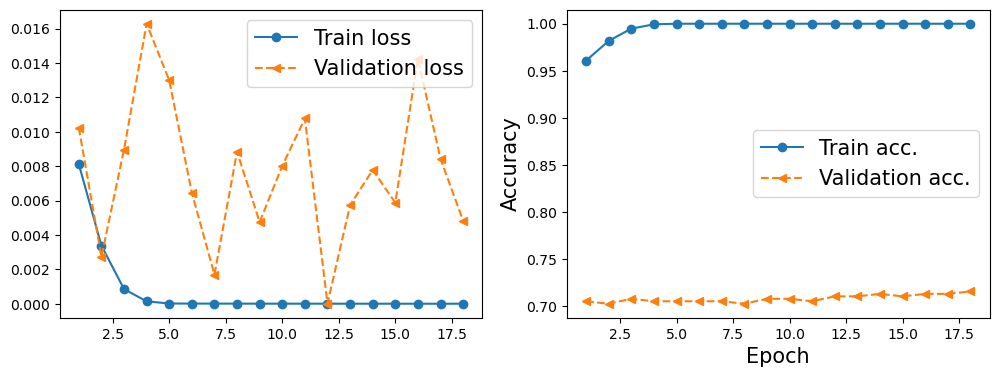

In [50]:
plot_learning_curves(hist)

### Evaluate the model with test dataset

Checking the results of the test dataset…



In [51]:
print("Checking the results of test dataset.")
accu_test, _ = evaluate(model, test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.709


In [52]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.71      0.76      0.73       111
         1.0       0.71      0.66      0.68       102

    accuracy                           0.71       213
   macro avg       0.71      0.71      0.71       213
weighted avg       0.71      0.71      0.71       213



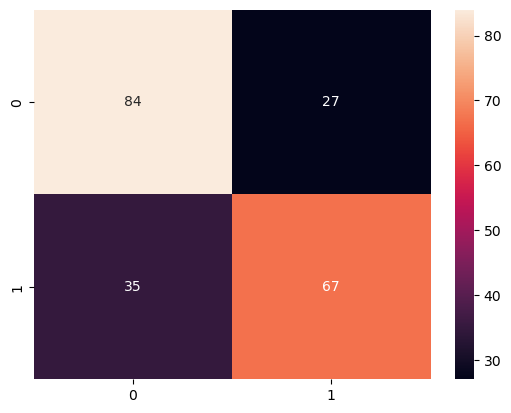

In [53]:
plot_confusion_matrix(model, test_dataloader)

In [54]:
def predict(text):
    with torch.no_grad():
        encoded_text = tokenizer(text)
        encoded_text.input_ids = torch.tensor(encoded_text.input_ids).to(device).unsqueeze(0)
        encoded_text.attention_mask = torch.tensor(encoded_text.attention_mask).to(device).unsqueeze(0)

        outputs = model(input_ids=encoded_text.input_ids, attention_mask=encoded_text.attention_mask)
        predicted_label = outputs.logits
        return predicted_label.argmax(1).item()

In [55]:
ex_text_str = 'The ePump Software shall define Fault ID 1 as follows:'

print("This is a %s" % predict(ex_text_str))

This is a 1


In [56]:
pred_text = "The IO Service shall select the XLR-PW DEV_INFO_DATA file if HPP_XLR_WIRING is grounded (logical 1) and bits AC_TYPE_BIT1 - AC_TYPE_BIT6 do not indicate a CFM engine configuration. NOTE: HPP_XLR_WIRING and bits AC_TYPE_BIT[1-6] are discrete inputs which are received on constant pins between hardware configurations. See 282100-ICD-x for more details."
predict(pred_text)

1

In [57]:
pred_text = "I shall like waffles"
predict(pred_text)

0

In [58]:
pred_text = "Bumblebe is red"
predict(pred_text)

0

In [59]:
pred_text = "Bumblebee is red"
predict(pred_text)

0

In [60]:
model_engine.save_16bit_model(f"./models/{model_name}/", f"{today}_{model_name}.pth")

[2024-05-14 08:33:30,325] [INFO] [logging.py:96:log_dist] [Rank 0] [Torch] Checkpoint global_step2016 is about to be saved!
[2024-05-14 08:33:30,325] [INFO] [engine.py:3596:save_16bit_model] Saving model weights to ./models/llama3_8b/2024-05-14_llama3_8b.pth, tag: global_step2016
[2024-05-14 08:33:30,326] [INFO] [torch_checkpoint_engine.py:21:save] [Torch] Saving ./models/llama3_8b/2024-05-14_llama3_8b.pth...
[2024-05-14 08:33:43,369] [INFO] [torch_checkpoint_engine.py:23:save] [Torch] Saved ./models/llama3_8b/2024-05-14_llama3_8b.pth.
[2024-05-14 08:33:43,369] [INFO] [torch_checkpoint_engine.py:33:commit] [Torch] Checkpoint global_step2016 is ready now!


True

In [19]:
model = torch.hub.load(
    "huggingface/pytorch-transformers",
    "modelForSequenceClassification",
    # "meta-llama/Llama-2-7b-hf",
    "meta-llama/Meta-Llama-3-8B",
    ignore_mismatched_sizes=True
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model.score = nn.Linear(in_features=4096, out_features=2)
model.config.pad_token_id = tokenizer.pad_token_id

In [16]:
model = model.to(device)

In [17]:
from datetime import datetime, date
model_name = "llama3_8b"
today = date.today().isoformat()


loaded_state_dict = torch.load(f"/home/it/environments/Genety/models/{model_name}/{today}_{model_name}.pth", mmap=True)
loaded_state_dict

OrderedDict([('model.embed_tokens.weight',
              tensor([[ 0.0317,  0.0227, -0.0164,  ...,  0.0066,  0.0151,  0.0326],
                      [ 0.0275, -0.0381, -0.0169,  ...,  0.0117,  0.0117, -0.0174],
                      [-0.0287, -0.0098,  0.0023,  ...,  0.0095,  0.0181, -0.0123],
                      ...,
                      [ 0.0146, -0.0074, -0.0189,  ..., -0.0002, -0.0100,  0.0220],
                      [ 0.0168,  0.0191,  0.0102,  ..., -0.0082, -0.0141, -0.0043],
                      [ 0.0033, -0.0194, -0.0119,  ..., -0.0374,  0.0095, -0.0008]],
                     dtype=torch.float16)),
             ('model.layers.0.self_attn.q_proj.weight',
              tensor([[ 7.6523e-03,  6.2180e-03, -1.5793e-02,  ...,  9.3689e-03,
                       -3.7994e-02,  6.8703e-03],
                      [-2.9449e-02,  1.4744e-03, -2.0203e-02,  ..., -1.5823e-02,
                        2.4994e-02, -1.5396e-02],
                      [ 2.5597e-03, -3.0334e-02,  1.9806e-02,  

In [21]:
model.load_state_dict(loaded_state_dict, assign=True, strict=False)

<All keys matched successfully>

In [22]:
torch.save(model, f"./models/{model_name}/{today}_{model_name}.pt")

# Hyperparameter tunning with Ray Tune

In [21]:
import os

# Disable Out-Of-Memory prevention for troubleshooting
os.environ["RAY_memory_monitor_refresh_ms"] = "0"
os.environ["RAY_memory_usage_threshold"] = "1"

In [22]:
import time
from datetime import datetime, date

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ray
import ray.train.torch

from ray import train, tune
from ray.train import RunConfig, ScalingConfig, Checkpoint
from ray.train.torch import TorchTrainer

from ray.tune.schedulers import ASHAScheduler

# DeepSpeed ZeRO-3 and Ray Train
import deepspeed
from deepspeed.accelerator import get_accelerator

In [23]:
ray.train.torch.get_device()

2024-05-14 11:09:54,300	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


device(type='cuda', index=0)

In [24]:
from torch.utils.data import DataLoader

# function passed to the DataLoader to process a batch of data as indicated
tokenizer.pad_token = tokenizer.eos_token

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask)
    
    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return encoded_x, torch.tensor(y, dtype=torch.long)

In [25]:
def train_func(model, optimizer, train_loader, max_norm, device):  
    model.train()
    
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0

    for idx, (encoded_x, label) in enumerate(train_loader):           
        label = label.to(device)
        
        
        encoded_x.input_ids = encoded_x.input_ids.to(device)
        encoded_x.attention_mask = encoded_x.attention_mask.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=encoded_x.input_ids, attention_mask=encoded_x.attention_mask)
        predicted_label = outputs.logits
        loss = criterion(predicted_label, label)
        
        # Deepspeed model engine, backward pass 
        model.backward(loss)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        
        # Deepspeed model engine, optimizer step
        model.step()
        
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        # Deepspeed model engine, empty cache
        model.empty_partition_cache()
         
    return total_acc / total_count, total_loss / total_count
        

def eval_func(model, data_loader, device):
    model.eval()
    
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (encoded_x, label) in enumerate(data_loader):
            label = label.to(device)
            
            encoded_x.input_ids = encoded_x.input_ids.to(device)
            encoded_x.attention_mask = encoded_x.attention_mask.to(device)
            
            outputs = model(input_ids=encoded_x.input_ids, attention_mask=encoded_x.attention_mask)
            predicted_label = outputs.logits
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

In [31]:
def create_model():
    with deepspeed.zero.Init():
        model = torch.hub.load(
            "huggingface/pytorch-transformers",
            "modelForSequenceClassification",
            # "meta-llama/Llama-2-7b-hf",
            "meta-llama/Meta-Llama-3-8B",
            ignore_mismatched_sizes=True
        )

    for i, parameter in enumerate(model.parameters()):
        parameter.requires_grad = False

    model.score = nn.Linear(in_features=4096, out_features=2)
    model.config.pad_token_id = tokenizer.pad_token_id


    return model

In [32]:
import os
import tempfile

today = date.today().isoformat()
model_name = "llama3_8b"
checkpoint_path = f"./models/{model_name}"
num_class = 2

def train_search(config):
    print("Starting train_search")
    
    # print(device)
    # print(config)
    # config_params = config["params"]
    config_params = config
    # print(config_params)

    print(" Before create_model")
    model = create_model()
    print("Model after create_model")
    
    train_iter = iter(list(train_df.itertuples(index=False, name=None)))
    test_iter = iter(list(test_df.itertuples(index=False, name=None)))
    train_dataset = to_map_style_dataset(train_iter)
    test_dataset = to_map_style_dataset(test_iter)
    num_train = int(len(train_dataset) * 0.8)
    split_train_, split_valid_ = random_split(
        train_dataset, [num_train, len(train_dataset) - num_train]
    )

    train_dataloader = DataLoader(
        split_train_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    valid_dataloader = DataLoader(
        split_valid_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    
    deepspeed_config = {
        "optimizer": {
            "type": "Adam",
            "params": {
                "lr": 0.01,
                "betas": [
                    0.8,
                    0.999
                ],
                "eps": 1e-8,
                "weight_decay": 3e-7,
            },
        },
        "scheduler": {
            "type": "WarmupLR",
            "params": {
                "warmup_min_lr": 0,
                "warmup_max_lr": 0.01,
                "warmup_num_steps": 1000,
            },
        },
        "train_batch_size": 16,
        # "train_micro_batch_size_per_gpu": "auto",
        # "gradient_accumulation_steps": "auto",
        "fp16": {"enabled": True},
        "zero_optimization": {
            "stage": 3,
            "offload_optimizer": {
                "device": "cpu",
            },
            "offload_param": {
                "device": "cpu",
            },
            "allgather_partitions": True,
            "allgather_bucket_size": 2e8,
            "reduce_scatter": True,
            "reduce_bucket_size": 2e8,
            "overlap_comm": True,
            "load_from_fp32_weights": True,
            "gather_16bit_weights_on_model_save": True,
            "contiguous_gradients": True,
            "stage3_prefetch_bucket_size": 0,
        },
        "gradient_accumulation_steps": 1,
        "train_batch_size": 16,
    }
    
    print("Before initializing deepspeed")
    
    
    # Initialize DeepSpeed Engine
    model, optimizer, _, lr_scheduler = deepspeed.initialize(
        model=model,
        model_parameters=model.parameters(),
        config=deepspeed_config,
    )
    device = get_accelerator().device_name(model.local_rank)
    print(f"deepspeed accelerator device: {device}")
    
    best_accu_val = 0.85
    for epoch in range(1, config_params["epochs"] + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train_func(model, optimizer, train_dataloader, config_params["max_norm"], device)
        accu_val, loss_val = eval_func(model, valid_dataloader, device)
        
            
        # Report checkpoint and metrics to Ray Train
        # ==============================================================
        with tempfile.TemporaryDirectory() as tmpdir:
            # Each worker saves its own checkpoint shard
            if accu_val > best_accu_val:
                model.save_checkpoint(tmpdir)
                checkpoint = Checkpoint.from_directory(tmpdir)
                best_accu_val = accu_val

            # Ensure all workers finished saving their checkpoint shard
            torch.distributed.barrier()

            # Report checkpoint shards from each worker in parallel
            ray.train.report(
                metrics={
                    # "loss_train": loss_train,
                    # "loss_val": loss_val,
                    "accuracy_train": accu_train,
                    "accuracy_val": accu_val,
                }, checkpoint=checkpoint
            )
        # ==============================================================
        
        get_accelerator().empty_cache()

In [33]:
import gc

model = None

gc.collect()
torch.cuda.empty_cache()
get_accelerator().empty_cache()

In [34]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 8.82586669921875, Global(GB): 23.64971923828125, Free(%): 0.373191182960537


In [35]:
import numpy as np
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

exp_name = model_name

space = {
    "lr": hp.loguniform("lr", -3, 1),
    # "momentum": hp.uniform("momentum", 0.1, 0.9),
    "epochs": hp.choice("epochs", [3]),
    "batch_size": hp.choice("batch_size", [16]),
    # "step_size": hp.randint("step_size", 1, 10),
    # "lr_gamma": hp.uniform("lr_gamma", 0.1, 0.9),
    "max_norm": hp.uniform("max_norm", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="accuracy_val", mode="max")

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

tuner = tune.Tuner(
    tune.with_resources(train_search, resources={"cpu":12, "gpu":1}),
    tune_config=tune.TuneConfig(
        num_samples=1,
        scheduler=ASHAScheduler(metric="accuracy_val", mode="max"), # Early stopping
        search_alg=hyperopt_search, # Hyperopt library for Hyper-parameter Optimization
    ),
    run_config=train.RunConfig(
        name=exp_name,
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="accuracy_val",
            num_to_keep=2,
            # checkpoint_at_end=True
        ),
    ),
)
results = tuner.fit()

(pid=40434) [2024-05-14 11:21:32,667] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
(pid=40434)  [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
(pid=40434)  [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
(pid=40434)  [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
(pid=40434)  [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
(pid=40434)  [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible
(train_search pid=40434) Starting train_search
(train_search pid=40434)  Before create_model
(train_search pid=40434) [2024-05-14 11:21:33,253] [INFO] [comm.py:637:init_distributed] cdb=None
(train_search pid=40434) [2024-05-14 11:21:33,253] [INFO] [comm.py:652:init_distributed] Not using the DeepSpee

(pid=40434) /home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
(pid=40434) /!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
(pid=40434) Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
(pid=40434)   warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


(train_search pid=40434) [2024-05-14 11:21:33,330] [INFO] [comm.py:702:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=10.1.1.204, master_port=29500
(train_search pid=40434) [2024-05-14 11:21:33,330] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


(train_search pid=40434) [W socket.cpp:464] [c10d] The server socket has failed to bind to [::]:29500 (errno: 98 - Address already in use).
(train_search pid=40434) [W socket.cpp:464] [c10d] The server socket has failed to bind to 0.0.0.0:29500 (errno: 98 - Address already in use).
(train_search pid=40434) [E socket.cpp:500] [c10d] The server socket has failed to listen on any local network address.
2024-05-14 11:21:33,456	ERROR tune_controller.py:1331 -- Trial task failed for trial train_search_ad89ada5
Traceback (most recent call last):
  File "/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/it/anaconda3/envs/genety/lib/python3.11/site-pa

In [ ]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d["accuracy_val"].plot() for d in dfs.values()]

In [ ]:
best_result = results.get_best_result("accuracy_val", "max")
best_result.config

In [ ]:
best_result.metrics_dataframe

In [ ]:
import matplotlib.pyplot as plt

df = best_result.metrics_dataframe

plt.plot(df['accuracy_train'], label='accuracy_train')
plt.plot(df['accuracy_val'], label='accuracy_val')

plt.legend(title='')

plt.show()

In [ ]:
best_checkpoints = best_result.best_checkpoints
best_checkpoints

In [ ]:
best_checkpoint = best_result.get_best_checkpoint("accuracy_val", mode="max")

In [ ]:
next(x for x in best_checkpoints if x[0].path == best_checkpoint.path)

In [ ]:
state_dict = torch.load(os.path.join(best_checkpoint.path, "model.pth"))

model = create_model()

model.load_state_dict(state_dict)

In [ ]:
uq_path = today + "_" + "_".join(best_result.path.split("=")[0].split("/")[-2:])
save_path = os.path.join(f'./models/{model_name}', uq_path + "_model.pt")
torch.save(model, save_path)